In [1]:
from glob import glob 
#file_list = glob("P" + "*.*", recursive = True)
file_list = glob("Dublin_Jun2014_swath_refl_VIs/Dublin_Jun2014_1_at-sensor_refl_L1G",recursive = True)
for i in file_list:
    print("Element: " + i)
# print("List of filenames:", file_list)

Element: Dublin_Jun2014_swath_refl_VIs/Dublin_Jun2014_1_at-sensor_refl_L1G


In [2]:
import pandas as pd
metadata_list = glob("Dublin_Jun2014_swath_refl_VIs/Dublin_Jun2014_1_at-sensor_refl_L1G.hdr")
header_info = pd.read_table(metadata_list[0], header=None)
# header_info = pd.read_table(file_list[1], header=None)
header_info.columns = ["metadata"]
print(header_info)

                                             metadata
0                                                ENVI
1                                     description = {
2               NASA G-LiHT, Dublin_Jun2014, Track 1}
3                                       samples = 651
4                                      lines   = 8524
5                                       bands   = 114
6                                   header offset = 0
7                           file type = ENVI Standard
8                                       data type = 2
9                                    interleave = bsq
10                              sensor type = Unknown
11                                     byte order = 0
12  map info = {UTM, 1.000, 1.000, 738973.302, 475...
13  coordinate system string = {PROJCS["UTM_Zone_1...
14                         default bands = {54,33,15}
15                      wavelength units = Nanometers
16  z plot titles = {Wavelength (nm), Reflectance ...
17                      defa

In [3]:
print(metadata_list)
print(file_list)

['Dublin_Jun2014_swath_refl_VIs/Dublin_Jun2014_1_at-sensor_refl_L1G.hdr']
['Dublin_Jun2014_swath_refl_VIs/Dublin_Jun2014_1_at-sensor_refl_L1G']


In [4]:
##!pip install spectral
from spectral import *

In [5]:
# img = envi.open(file_list[1], )
# img1 = envi.open(file_list[3], )
# img2 = envi.open(file_list[5], )
img = envi.open(metadata_list[0], )
# img1 = envi.open(metadata_list[1], )
# img2 = envi.open(metadata_list[2], )

In [6]:
#Load image as an array
arr = img.load()
# arr = img
# arr1 = img1.load()
# arr2 = img2.load()

In [7]:
#Functions for working with images
import cv2
import matplotlib.pyplot as plt
import numpy as np

# def show_image(img1,img2,img3):
def show_image(img1):
    fig1, ax1 = plt.subplots(figsize=(5, 5))
    ax1.imshow(img1, cmap = 'gray')
    # ax1.imshow(img2, cmap = 'gray')
    # ax1.imshow(img3, cmap = 'gray')

def increase_brightness(img, value=80):
    img = img.astype(np.uint8)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def create_rgb(hyper_cube):
    rgb_image = hyper_cube[:,:,[20,36,5]]
    rgb_image = cv2.normalize(rgb_image, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    rgb_image = rgb_image.astype(np.uint8)
    rgb_image = increase_brightness(rgb_image)
    return rgb_image

In [8]:
def spectralSlicing(img, dim):
    #declaring variables
    inBounds = True
    x,y = 0,0
    ret = []
#     print(img.shape)
    while(inBounds):
        #slice dim pixels in x and y and then take all 114 wavelengths 
        frame = img[x:(x+dim),y:(y+dim),:]
        if(frame.any() != 0): #if the Frame is blank, don't append it
            ret.append(frame)
#         print(frame.shape)
        #indexing and edge detection
        x += dim
        if((x+dim) > img.shape[0]):
            x = 0
            y += dim
            if((y+dim) > img.shape[1]):
                inBounds = False
#    print(len(ret))
    return ret

In [9]:
def showframes(frames):
    for i in range(len(frames)):
        frame = create_rgb(frames[i])
        show_image(frame)

In [10]:
miniframes = spectralSlicing(img,240)

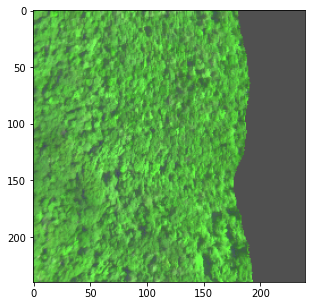

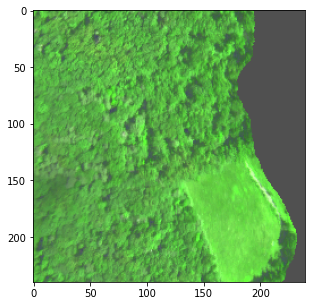

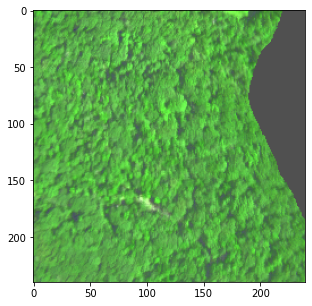

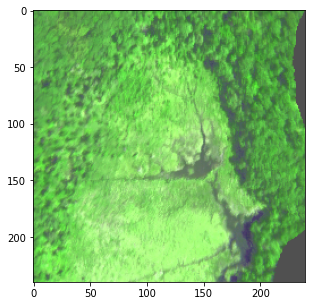

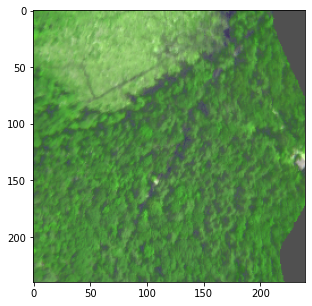

In [11]:
showframes(miniframes[50:55])
# rgb_img = create_rgb(arr) 
# show_image(rgb_img)

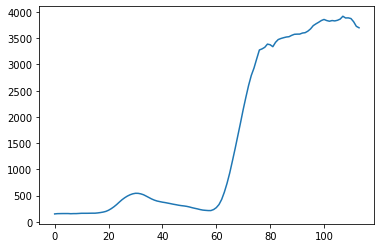

In [12]:
# microframes = spectralSlicing(miniframes[0],80)
plt.plot(miniframes[2][80,130,:])

/home/jcristia/eleg404/lib/python3.10/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jcristia/eleg404/lib/python3.10/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10488
3795


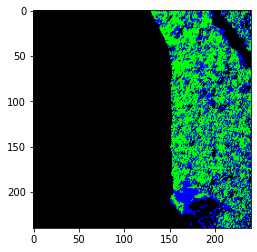

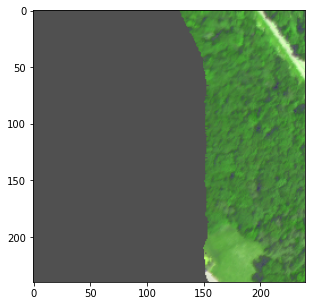

In [13]:
def isTreePixbyPix(frame,treePixel):
#     aTreeFFT = np.fft.fft(treePixel[0:])
    heatmap = np.zeros([frame.shape[0],frame.shape[1],3])  # Creating Heatmap with zeros and ones
    treePixels = []
    otherTreePixels = []
    nonTreePixels = []
    coef = []
    for x in range(frame.shape[0]):
        for y in range(frame.shape[1]):
            cc = np.corrcoef(treePixel, frame[x,y,:])[0,1]
            if(cc > .9995):
                treePixels.append(frame[x,y,:])
                heatmap[x,y,1] = 255
                coef.append(cc)
            if(cc > .9980 and cc < .9995):
                otherTreePixels.append(frame[x,y,:])
                heatmap[x,y,2] = 255
            if(cc < .9980):
                nonTreePixels.append(frame[x,y,:])
#     a = np.histogram(coef[:], bins='auto')
#     plt.plot(a)
#     print(coef[:])
    return treePixels, otherTreePixels, nonTreePixels, heatmap
t, ot, n, hmp = isTreePixbyPix(miniframes[4],miniframes[2][200,150,0:])
plt.imshow(hmp)
showframes(miniframes[4:5])
print(len(t))
print(len(n))

In [14]:
##making cubable
bigT = []
bigT.append(t[1])
bigOT = []
bigOT.append(ot[1])
bigN = []
bigN.append(n[1]) 
bigTtest = []
bigTtest.append(t[1])
bigOTtest = []
bigOTtest.append(ot[1])
bigNtest = []
bigNtest.append(n[1]) 
trainFrames = [4,0,1,35,37,41]
testFrames = [2,13,53]
for i in trainFrames:
    t, ot, n, hmp = isTreePixbyPix(miniframes[i],miniframes[2][200,150,0:])
    bigT+=t
    bigOT+=ot
    bigN+=n
for i in testFrames:
    t, ot, n, hmp = isTreePixbyPix(miniframes[i],miniframes[2][200,150,0:])
    bigTtest+=t
    bigOTtest+=ot
    bigNtest+=n

In [15]:
tCube = []
otCube = []
nCube = []
tCubetest = []
otCubetest = []
nCubetest = []
for i in range(len(bigT)//4096):
    index = i*4096
    tCube.append([bigT[index:index+4096],1])
for i in range(len(bigOT)//4096):
    index = i*4096
    otCube.append([bigOT[index:index+4096],2])
for i in range(len(bigN)//4096):
    index = i*4096
    nCube.append([bigN[index:index+4096],0])
for i in range(len(bigTtest)//4096):
    index = i*4096
    tCubetest.append([bigTtest[index:index+4096],1])
for i in range(len(bigOTtest)//4096):
    index = i*4096
    otCubetest.append([bigOTtest[index:index+4096],2])
for i in range(len(bigNtest)//4096):
    index = i*4096
    nCubetest.append([bigNtest[index:index+4096],0])

In [16]:
print(len(tCube),len(tCube[0]))
print(len(nCube),len(nCube[0]))
print(len(otCube),len(otCube[0]))

15 2
18 2
21 2


In [17]:
import h5py
bigDataCube = tCube + otCube + nCube 
bigDataCubetest = tCubetest + otCubetest + nCubetest
np.random.shuffle(bigDataCube)
np.random.shuffle(bigDataCubetest)
trainingData, trainingLabels = zip(*bigDataCube)
testingData, testingLabels = zip(*bigDataCubetest)
hf = h5py.File('treeVSnot.h5','w')
hf.create_dataset('trainingData', data=trainingData)
hf.create_dataset('trainingLabels', data=trainingLabels)
hf.create_dataset('testingLabels', data=testingLabels)
hf.create_dataset('testingData', data=testingData)
hf.close()

In [18]:
print(len(trainingData))
print(len(trainingData[1]))
print(len(testingData))
print(len(testingData[1]))

54
4096
25
4096
